In [76]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
source_folder='DATASET'
destination_folder = NEG_PATH

In [10]:
# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate over each directory in the source folder
for directory in os.listdir(source_folder):
    directory_path = os.path.join(source_folder, directory)
    if not os.path.isdir(directory_path):
        continue
    
    # Initialize the counter for renaming
    counter = 0
    
    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        
        # Generate the new filename with an incrementing number and .jpg extension
        new_filename = str(counter) + '.jpg'
        new_file_path = os.path.join(destination_folder, new_filename)
        
        # Check if the new filename already exists
        while os.path.exists(new_file_path):
            counter += 1
            new_filename = str(counter) + '.jpg'
            new_file_path = os.path.join(destination_folder, new_filename)
        
        # Convert the file from PNG to JPG and save it with the new filename
        img = Image.open(file_path)
        img = img.convert("RGB")
        img.save(new_file_path, "JPEG")
        
        # Increment the counter
        counter += 1

## Collect Positive and Anchor Classes

In [79]:
# Import uuid library to generate unique image names
import uuid

In [80]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\48daa084-0b1b-11ee-bf25-cbf39652bf65.jpg'

In [83]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

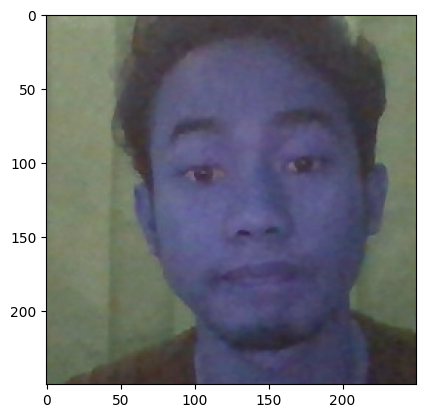

In [84]:
plt.imshow(frame)

## Load and Preprocess Images
### Get Image Directories

In [85]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)

In [86]:
dir_test = anchor.as_numpy_iterator()

In [87]:
print(dir_test.next())

b'data\\anchor\\1417154a-0ac8-11ee-a792-cbf39652bf65.jpg'


### Preprocessing - Scale and Resize

In [88]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [89]:
img = preprocess('data\\anchor\\1417154a-0ac8-11ee-a792-cbf39652bf65.jpg')

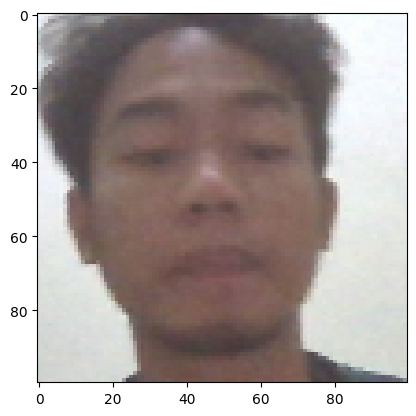

In [90]:
img.numpy().max() 
plt.imshow(img)

In [91]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## Create Labelled Dataset

In [92]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [93]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [94]:
samples = data.as_numpy_iterator()

In [95]:
exampple = samples.next()
exampple

(b'data\\anchor\\5eebfa26-0b1b-11ee-b8d4-cbf39652bf65.jpg',
 b'data\\positive\\3310be6d-0ac8-11ee-808f-cbf39652bf65.jpg',
 1.0)

## Build Train and Test Partition

In [96]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

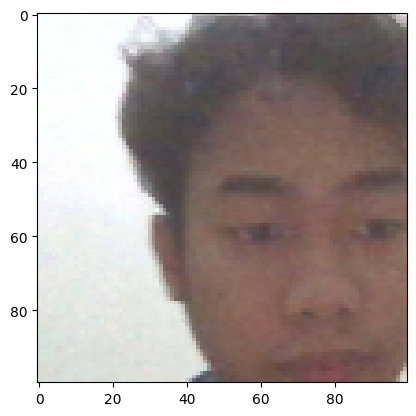

In [97]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [98]:
res[2]

1.0

In [99]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [100]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [101]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering
### Build Embedding Layer

In [102]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [103]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [104]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [105]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

### Build Distance Layer

In [106]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [107]:
l1 = L1Dist()

In [108]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

### Make Siamese Model

In [109]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [110]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [111]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [112]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [113]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [114]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Training
### Setup Loss and Optimizer

In [115]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### Establish Checkpoints

In [116]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [117]:
os.listdir(checkpoint_dir)

['checkpoint',
 'ckpt-1.data-00000-of-00001',
 'ckpt-1.index',
 'ckpt-2.data-00000-of-00001',
 'ckpt-2.index',
 'ckpt-3.data-00000-of-00001',
 'ckpt-3.index',
 'ckpt-4.data-00000-of-00001',
 'ckpt-4.index',
 'ckpt-5.data-00000-of-00001',
 'ckpt-5.index']

### Build Train Step Function

In [118]:
test_batch = train_data.as_numpy_iterator()

In [119]:
batch_1 = test_batch.next()

In [120]:
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.],
      dtype=float32)

In [121]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

### Build Training Loop

In [122]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [123]:
EPOCHS = 50

In [124]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 133s 3s/step

 Epoch 2/50
44/44 [==============================] - 134s 3s/step

 Epoch 3/50
44/44 [==============================] - 141s 3s/step

 Epoch 4/50
44/44 [==============================] - 173s 4s/step

 Epoch 5/50
44/44 [==============================] - 162s 4s/step

 Epoch 6/50
44/44 [==============================] - 169s 4s/step

 Epoch 7/50
44/44 [==============================] - 149s 3s/step

 Epoch 8/50
44/44 [==============================] - 132s 3s/step

 Epoch 9/50
44/44 [==============================] - 131s 3s/step

 Epoch 10/50
44/44 [==============================] - 137s 3s/step

 Epoch 11/50
44/44 [==============================] - 132s 3s/step

 Epoch 12/50
44/44 [==============================] - 133s 3s/step

 Epoch 13/50
44/44 [==================

## Evaluate Model
### Import Metrics

In [125]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [126]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [127]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 662ms/step


array([[5.8134005e-16],
       [8.4614489e-16],
       [9.9722683e-01],
       [1.0000000e+00],
       [2.8321335e-16],
       [3.1672345e-11],
       [3.0528190e-16],
       [9.9999958e-01],
       [6.2630380e-11],
       [5.8094127e-15],
       [1.0000000e+00],
       [9.9969870e-01],
       [9.5571595e-10],
       [4.0810825e-08],
       [4.4764099e-11],
       [3.3891279e-09]], dtype=float32)

In [128]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]

In [129]:
y_true

array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

### Calculate Metrics

In [130]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [131]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

### Visualize the Results

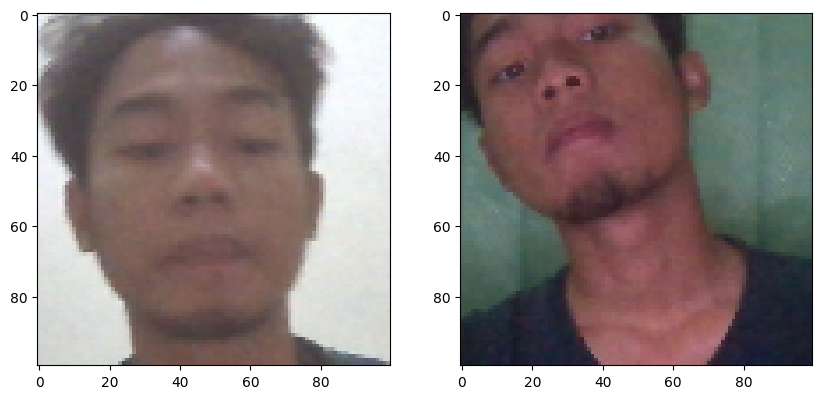

In [150]:
# Set plot size 
plt.figure(figsize=(10,8))

a = 3

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[a])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[a])

# Renders cleanly
plt.show()

### Save Model

In [151]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [152]:
L1Dist

__main__.L1Dist

In [153]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [154]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 621ms/step


array([[3.5297062e-16],
       [8.4614489e-16],
       [9.9722683e-01],
       [1.0000000e+00],
       [2.8321335e-16],
       [3.1672345e-11],
       [3.0513986e-16],
       [9.9999958e-01],
       [6.2630380e-11],
       [5.8188165e-15],
       [1.0000000e+00],
       [9.9969870e-01],
       [1.0762777e-09],
       [4.0810825e-08],
       [4.4283358e-11],
       [3.3891279e-09]], dtype=float32)

In [155]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Real Time Test

### Verification Function

In [156]:
# application_data\verification_images

In [157]:
os.listdir(os.path.join('application_data', 'verification_images'))

['226373b3-0ac8-11ee-b77e-cbf39652bf65.jpg',
 '23645a8c-0ac8-11ee-8032-cbf39652bf65.jpg',
 '23d11c08-0ac8-11ee-b73d-cbf39652bf65.jpg',
 '244af13d-0ac8-11ee-a3e1-cbf39652bf65.jpg',
 '2459b9d7-0ac8-11ee-9842-cbf39652bf65.jpg',
 '251972b0-0ac8-11ee-8193-cbf39652bf65.jpg',
 '25c793b0-0ac8-11ee-bab2-cbf39652bf65.jpg',
 '260f0411-0ac8-11ee-a3f5-cbf39652bf65.jpg',
 '26377714-0ac8-11ee-a94d-cbf39652bf65.jpg',
 '264aeb61-0ac8-11ee-a435-cbf39652bf65.jpg',
 '27283b9e-0ac8-11ee-b450-cbf39652bf65.jpg',
 '27367a5d-0ac8-11ee-acb3-cbf39652bf65.jpg',
 '273b4d0b-0ac8-11ee-9f0e-cbf39652bf65.jpg',
 '2768822f-0ac8-11ee-95d7-cbf39652bf65.jpg',
 '27ba3ffc-0ac8-11ee-b47e-cbf39652bf65.jpg',
 '281460e2-0ac8-11ee-84e6-cbf39652bf65.jpg',
 '289c9923-0ac8-11ee-ab8e-cbf39652bf65.jpg',
 '290b60f4-0ac8-11ee-837e-cbf39652bf65.jpg',
 '299cae80-0ac8-11ee-a3ab-cbf39652bf65.jpg',
 '2a220845-0ac8-11ee-ba6a-cbf39652bf65.jpg',
 '2a279aa3-0ac8-11ee-b028-cbf39652bf65.jpg',
 '2a2c5c5c-0ac8-11ee-92ee-cbf39652bf65.jpg',
 '2a59fdb8

In [158]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [159]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\226373b3-0ac8-11ee-b77e-cbf39652bf65.jpg
application_data\verification_images\23645a8c-0ac8-11ee-8032-cbf39652bf65.jpg
application_data\verification_images\23d11c08-0ac8-11ee-b73d-cbf39652bf65.jpg
application_data\verification_images\244af13d-0ac8-11ee-a3e1-cbf39652bf65.jpg
application_data\verification_images\2459b9d7-0ac8-11ee-9842-cbf39652bf65.jpg
application_data\verification_images\251972b0-0ac8-11ee-8193-cbf39652bf65.jpg
application_data\verification_images\25c793b0-0ac8-11ee-bab2-cbf39652bf65.jpg
application_data\verification_images\260f0411-0ac8-11ee-a3f5-cbf39652bf65.jpg
application_data\verification_images\26377714-0ac8-11ee-a94d-cbf39652bf65.jpg
application_data\verification_images\264aeb61-0ac8-11ee-a435-cbf39652bf65.jpg
application_data\verification_images\27283b9e-0ac8-11ee-b450-cbf39652bf65.jpg
application_data\verification_images\27367a5d-0ac8-11ee-acb3-cbf39652bf65.jpg
application_data\verification_images\273b4d0b-0ac8-11ee-9f0e-cbf

In [160]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## OpenCV Real Time Verification

In [161]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 61ms/step
True
1/1 [==============================] - 0s 77ms/step
True
1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 68ms/step
True
1/1 [==============================] - 0s 81ms/step
False
1/1 [==============================] - 0s 84ms/step
True
1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 102ms/step
False
1/1 [==============================] - 0s 89ms/step
False
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step
False
1/1 [==============================] - 0s 71ms/step
True
1/1 [==============================] - 0s 64ms/step
True
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 70ms/step
True
1/1 [==============================] - 0s 73ms/step
True
1/1 [==============================] - 0s 74ms/step
True
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 74ms/step
False
1/1 [==============================] - 0s 78ms/step
True
1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 69ms/step
True
1/1 [==============================] - 0s 84ms/step
True
1/1 [==============================] - 0s 81ms/step
False


In [165]:
np.sum(np.squeeze(results))

0.00026625005

In [163]:
np.squeeze(results)

array([1.2562244e-06, 2.3356224e-06, 2.6808189e-05, 3.9241545e-06,
       2.2890804e-06, 2.7908740e-07, 1.7915158e-06, 1.1147102e-06,
       8.3762154e-07, 1.8244726e-05, 3.1664578e-07, 3.7857333e-07,
       5.0897444e-07, 9.1995065e-07, 2.1321221e-06, 3.1017737e-07,
       8.1252928e-08, 1.2555282e-07, 3.8072142e-07, 2.6664759e-07,
       2.7757309e-07, 5.3519221e-07, 4.2544884e-06, 4.2431102e-06,
       1.6710126e-07, 8.1731045e-08, 8.1388649e-08, 9.1153737e-08,
       2.9016735e-07, 1.3848230e-06, 2.2052630e-07, 1.6045652e-07,
       1.0653030e-07, 8.0300637e-08, 9.5748661e-08, 1.5316506e-07,
       1.7671137e-07, 6.5284333e-08, 2.8896278e-07, 9.7549059e-07,
       3.2045769e-05, 1.2063645e-05, 1.2062552e-05, 3.1490501e-05,
       1.2017367e-06, 5.0935898e-07, 2.3673019e-06, 2.6858979e-06,
       4.7687354e-07, 1.9252488e-05, 2.2161696e-05, 5.3350493e-07,
       2.4057118e-07, 3.3668985e-07, 1.8899470e-06, 5.6997319e-06,
       2.6983091e-07, 2.0557503e-05, 2.1100164e-05, 1.2728361e